In [1]:
import os
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data 

In [3]:
#Transformation
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2 , contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406] , std = [0.229,0.224,0.225])
])

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(dataset_path , transform=image_transform)

len(dataset)

2300

In [5]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size , val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset , val_dataset = random_split(dataset, [train_size , val_size])

In [9]:
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=32 , shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [12]:
images[0].shape

torch.Size([3, 224, 224])

In [13]:
labels[0]   # i.e R_breakage

tensor(5)

In [14]:
images[0].permute(1,2,0).shape  # as I imshow expects pixels first and channel at last

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


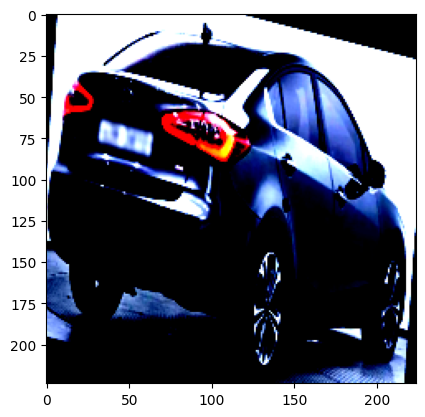

In [15]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

## Model1 CNN:

In [16]:
class CarClassiferCNN(nn.Module):
    def __init__(self ,num_classes):
        super().__init__()
        self.network = nn.Sequential(
              nn.Conv2d(in_channels=3 , out_channels=16 , kernel_size=3 , stride=1 , padding=1), # out = (16,224,224)
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (16,112,112)
              nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=3 , stride=1 , padding=1), # out = (32,112,112)
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (32,56,56)
              nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3 , stride=1 , padding=1), # out = (64,56,56)
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (64,28,28)
              nn.Flatten(),
              nn.Linear(64*28*28 , 512),
              nn.ReLU(),
              nn.Linear(512 , num_classes)
        )
        
    def forward(self,x):
        x = self.network(x)
        return x

In [17]:
# Instantiate the model , loss function and optimizer

model = CarClassiferCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)

In [18]:
def train_model(model , criterion, optimizer , epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        
        for batch_num , (images , labels) in enumerate(train_loader):
            images , labels = images.to(device) , labels.to(device)
            
            # Zero the parameter gradients 
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs , labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch:{batch_num+1} , Epoch: {epoch+1} , Loss: {loss.item():0.2f}")

            running_loss += loss.item()*images.size(0)  # it will calculate loss for whole batch
            
        epoch_loss = running_loss/len(train_loader.dataset)
        print(f"Epoch:[{epoch+1}/{epochs}] , Avg Loss: {epoch_loss:.4f}")
        
        
        # Validation
        
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images , labels in val_loader:
                images , labels = images.to(device) , labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs ,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(labels.cpu().numpy())
                
            print(f"*** Validation Accuracy : {100*correct / total:.2f}% ***")
     
    end = time.time()
    print(f"Execution Time:{end -start} seconds")
    return all_labels , all_predictions
                
            

In [19]:
# Instantiate the model , loss function and optimizer

model = CarClassiferCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)


all_labels , all_predictions =  train_model(model , criterion , optimizer , epochs=10)

Batch:10 , Epoch: 1 , Loss: 1.76
Batch:20 , Epoch: 1 , Loss: 1.65
Batch:30 , Epoch: 1 , Loss: 1.69
Batch:40 , Epoch: 1 , Loss: 1.59
Batch:50 , Epoch: 1 , Loss: 1.40
Epoch:[1/10] , Avg Loss: 1.6915
*** Validation Accuracy : 41.04% ***
Batch:10 , Epoch: 2 , Loss: 1.39
Batch:20 , Epoch: 2 , Loss: 1.35
Batch:30 , Epoch: 2 , Loss: 1.26
Batch:40 , Epoch: 2 , Loss: 1.11
Batch:50 , Epoch: 2 , Loss: 1.28
Epoch:[2/10] , Avg Loss: 1.2331
*** Validation Accuracy : 55.48% ***
Batch:10 , Epoch: 3 , Loss: 1.08
Batch:20 , Epoch: 3 , Loss: 1.26
Batch:30 , Epoch: 3 , Loss: 1.18
Batch:40 , Epoch: 3 , Loss: 1.14
Batch:50 , Epoch: 3 , Loss: 1.05
Epoch:[3/10] , Avg Loss: 1.0622
*** Validation Accuracy : 55.65% ***
Batch:10 , Epoch: 4 , Loss: 0.81
Batch:20 , Epoch: 4 , Loss: 0.82
Batch:30 , Epoch: 4 , Loss: 1.19
Batch:40 , Epoch: 4 , Loss: 1.06
Batch:50 , Epoch: 4 , Loss: 1.27
Epoch:[4/10] , Avg Loss: 0.9610
*** Validation Accuracy : 55.48% ***
Batch:10 , Epoch: 5 , Loss: 0.72
Batch:20 , Epoch: 5 , Loss: 1.1

## Model1 CNN with Regularisation

In [20]:
class CarClassiferCNNWithRegularization(nn.Module):
    def __init__(self ,num_classes):
        super().__init__()
        self.network = nn.Sequential(
              nn.Conv2d(in_channels=3 , out_channels=16 , kernel_size=3 , stride=1 , padding=1), # out = (16,224,224)
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (16,112,112)
              nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=3 , stride=1 , padding=1), # out = (32,112,112)
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (32,56,56)
              nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3 , stride=1 , padding=1), # out = (64,56,56)
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0), # out = (64,28,28)
              nn.Flatten(),
              nn.Linear(64*28*28 , 512),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(512 , num_classes)
        )
        
    def forward(self,x):
        x = self.network(x)
        return x

In [21]:
# Instantiate the model , loss function and optimizer

model = CarClassiferCNNWithRegularization(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001 , weight_decay=1e-4)


all_labels , all_predictions =  train_model(model , criterion , optimizer , epochs=10)

Batch:10 , Epoch: 1 , Loss: 9.90
Batch:20 , Epoch: 1 , Loss: 6.70
Batch:30 , Epoch: 1 , Loss: 2.40
Batch:40 , Epoch: 1 , Loss: 1.47
Batch:50 , Epoch: 1 , Loss: 1.62
Epoch:[1/10] , Avg Loss: 7.4395
*** Validation Accuracy : 42.96% ***
Batch:10 , Epoch: 2 , Loss: 1.16
Batch:20 , Epoch: 2 , Loss: 1.27
Batch:30 , Epoch: 2 , Loss: 1.49
Batch:40 , Epoch: 2 , Loss: 1.43
Batch:50 , Epoch: 2 , Loss: 1.10
Epoch:[2/10] , Avg Loss: 1.3955
*** Validation Accuracy : 50.09% ***
Batch:10 , Epoch: 3 , Loss: 1.60
Batch:20 , Epoch: 3 , Loss: 1.35
Batch:30 , Epoch: 3 , Loss: 1.20
Batch:40 , Epoch: 3 , Loss: 1.37
Batch:50 , Epoch: 3 , Loss: 1.14
Epoch:[3/10] , Avg Loss: 1.2327
*** Validation Accuracy : 50.43% ***
Batch:10 , Epoch: 4 , Loss: 1.28
Batch:20 , Epoch: 4 , Loss: 1.20
Batch:30 , Epoch: 4 , Loss: 1.11
Batch:40 , Epoch: 4 , Loss: 1.06
Batch:50 , Epoch: 4 , Loss: 1.31
Epoch:[4/10] , Avg Loss: 1.2258
*** Validation Accuracy : 53.74% ***
Batch:10 , Epoch: 5 , Loss: 1.04
Batch:20 , Epoch: 5 , Loss: 1.1

***Regularization was implemented using L2 penalty (weight_decay=1e-4) in the Adam optimizer, which likely contributed to underfitting in the previous results by overly constraining the model's capacity to learn, resulting in higher loss and only a slight improvement in validation accuracy.***

## Model 3: Transfer Learning with EfficientNet

In [22]:
class CarClassfierEfficientNet(nn.Module):
    def __init__(self , num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights="DEFAULT")
        
        for param in self.model.parameters():   # Freezing the internal layer of trained model
            param.requires_grad =False           
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
                  nn.Dropout(0.5),
                  nn.Linear(in_features , num_classes)
        )
        
    def forward(self , x):
        x = self.model(x)
        return x

In [23]:
# Instantiate the model , loss function and optimizer

model = CarClassfierEfficientNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


all_labels , all_predictions =  train_model(model , criterion , optimizer , epochs=10)

Batch:10 , Epoch: 1 , Loss: 1.50
Batch:20 , Epoch: 1 , Loss: 1.51
Batch:30 , Epoch: 1 , Loss: 1.41
Batch:40 , Epoch: 1 , Loss: 1.38
Batch:50 , Epoch: 1 , Loss: 1.26
Epoch:[1/10] , Avg Loss: 1.4629
*** Validation Accuracy : 57.22% ***
Batch:10 , Epoch: 2 , Loss: 1.04
Batch:20 , Epoch: 2 , Loss: 1.11
Batch:30 , Epoch: 2 , Loss: 1.10
Batch:40 , Epoch: 2 , Loss: 1.13
Batch:50 , Epoch: 2 , Loss: 1.02
Epoch:[2/10] , Avg Loss: 1.1413
*** Validation Accuracy : 59.65% ***
Batch:10 , Epoch: 3 , Loss: 0.85
Batch:20 , Epoch: 3 , Loss: 1.08
Batch:30 , Epoch: 3 , Loss: 1.02
Batch:40 , Epoch: 3 , Loss: 1.16
Batch:50 , Epoch: 3 , Loss: 0.98
Epoch:[3/10] , Avg Loss: 1.0204
*** Validation Accuracy : 61.04% ***
Batch:10 , Epoch: 4 , Loss: 0.84
Batch:20 , Epoch: 4 , Loss: 1.01
Batch:30 , Epoch: 4 , Loss: 0.99
Batch:40 , Epoch: 4 , Loss: 1.06
Batch:50 , Epoch: 4 , Loss: 1.09
Epoch:[4/10] , Avg Loss: 0.9611
*** Validation Accuracy : 66.26% ***
Batch:10 , Epoch: 5 , Loss: 0.73
Batch:20 , Epoch: 5 , Loss: 0.7

***Using transfer learning with EfficientNet, the model achieved a significantly lower average loss of 0.1287 and a high validation accuracy of 83.30%, indicating successful learning and good generalization.***

## Model 4: Transfer Learning with ResNet

In [24]:
class CarClassfieResNet(nn.Module):
    def __init__(self , num_classes , dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights="DEFAULT")
        
        for param in self.model.parameters():   # Freezing the internal layers of trained model
            param.requires_grad =False           
        
        
        for param in self.model.layer4.parameters():  # unfreezing layer4 and fc
            param.requires_grad = True 
            
            
        
        self.model.fc = nn.Sequential(
                  nn.Dropout(dropout_rate),
                  nn.Linear(self.model.fc.in_features , num_classes)
        )
        
    def forward(self , x):
        x = self.model(x)
        return x

In [25]:
# Instantiate the model , loss function and optimizer

model = CarClassfieResNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


all_labels , all_predictions =  train_model(model , criterion , optimizer , epochs=10)

Batch:10 , Epoch: 1 , Loss: 1.17
Batch:20 , Epoch: 1 , Loss: 0.68
Batch:30 , Epoch: 1 , Loss: 0.77
Batch:40 , Epoch: 1 , Loss: 0.79
Batch:50 , Epoch: 1 , Loss: 0.61
Epoch:[1/10] , Avg Loss: 0.8590
*** Validation Accuracy : 76.00% ***
Batch:10 , Epoch: 2 , Loss: 0.53
Batch:20 , Epoch: 2 , Loss: 0.55
Batch:30 , Epoch: 2 , Loss: 0.55
Batch:40 , Epoch: 2 , Loss: 0.51
Batch:50 , Epoch: 2 , Loss: 0.68
Epoch:[2/10] , Avg Loss: 0.4736
*** Validation Accuracy : 72.35% ***
Batch:10 , Epoch: 3 , Loss: 0.35
Batch:20 , Epoch: 3 , Loss: 0.35
Batch:30 , Epoch: 3 , Loss: 0.28
Batch:40 , Epoch: 3 , Loss: 0.19
Batch:50 , Epoch: 3 , Loss: 0.29
Epoch:[3/10] , Avg Loss: 0.3420
*** Validation Accuracy : 75.30% ***
Batch:10 , Epoch: 4 , Loss: 0.10
Batch:20 , Epoch: 4 , Loss: 0.27
Batch:30 , Epoch: 4 , Loss: 0.17
Batch:40 , Epoch: 4 , Loss: 0.22
Batch:50 , Epoch: 4 , Loss: 0.18
Epoch:[4/10] , Avg Loss: 0.2527
*** Validation Accuracy : 77.91% ***
Batch:10 , Epoch: 5 , Loss: 0.40
Batch:20 , Epoch: 5 , Loss: 0.3

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [26]:
model = CarClassfieResNet(num_classes = num_classes , dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)


labels , predictions =  train_model(model , criterion , optimizer , epochs=10)

Batch:10 , Epoch: 1 , Loss: 1.31
Batch:20 , Epoch: 1 , Loss: 1.33
Batch:30 , Epoch: 1 , Loss: 0.74
Batch:40 , Epoch: 1 , Loss: 0.73
Batch:50 , Epoch: 1 , Loss: 0.90
Epoch:[1/10] , Avg Loss: 0.8906
*** Validation Accuracy : 67.13% ***
Batch:10 , Epoch: 2 , Loss: 0.31
Batch:20 , Epoch: 2 , Loss: 0.50
Batch:30 , Epoch: 2 , Loss: 0.72
Batch:40 , Epoch: 2 , Loss: 0.47
Batch:50 , Epoch: 2 , Loss: 0.65
Epoch:[2/10] , Avg Loss: 0.5085
*** Validation Accuracy : 77.22% ***
Batch:10 , Epoch: 3 , Loss: 0.49
Batch:20 , Epoch: 3 , Loss: 0.30
Batch:30 , Epoch: 3 , Loss: 0.27
Batch:40 , Epoch: 3 , Loss: 0.25
Batch:50 , Epoch: 3 , Loss: 0.67
Epoch:[3/10] , Avg Loss: 0.3298
*** Validation Accuracy : 77.22% ***
Batch:10 , Epoch: 4 , Loss: 0.18
Batch:20 , Epoch: 4 , Loss: 0.30
Batch:30 , Epoch: 4 , Loss: 0.53
Batch:40 , Epoch: 4 , Loss: 0.48
Batch:50 , Epoch: 4 , Loss: 0.26
Epoch:[4/10] , Avg Loss: 0.2723
*** Validation Accuracy : 77.04% ***
Batch:10 , Epoch: 5 , Loss: 0.39
Batch:20 , Epoch: 5 , Loss: 0.2

### Model Evaluation using Confusion Matrix and Classification Report

In [31]:
from sklearn.metrics import classification_report


report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       135
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        76
           5       1.00      1.00      1.00        82

    accuracy                           1.00       575
   macro avg       1.00      1.00      1.00       575
weighted avg       1.00      1.00      1.00       575



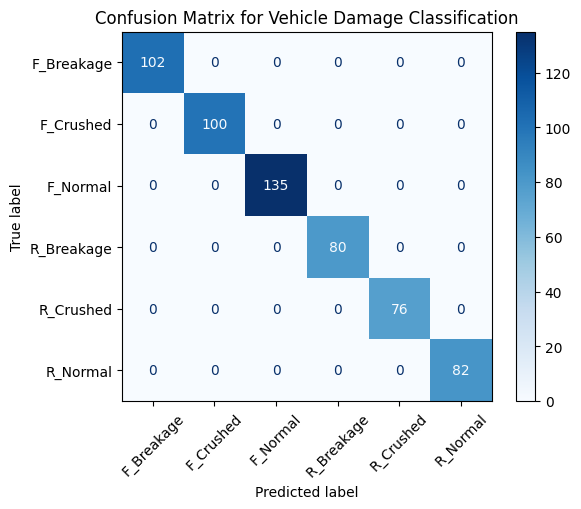

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [29]:
torch.save(model.state_dict(), 'saved_model1.pth')